In [1]:
import yaml
import healpy as hp
import numpy as np
import os
import scipy

from plancklens import utils

from jointmap.plots import CMBLensingPlot 

import os
import numpy as np

from delensalot.core.iterator import statics

import yaml

import matplotlib.pyplot as plt



mpisupport: False, pmisupport: False
disabling mpi
Using lenspyx alm2map


In [2]:
def bin_theory(cl, bin_edges):
    l = np.arange(len(cl))
    sums = scipy.stats.binned_statistic(l, l, statistic="sum", bins=bin_edges)
    cl = scipy.stats.binned_statistic(l, l*cl, statistic="sum", bins=bin_edges)
    cl = cl[0] / sums[0]
    el = (bin_edges[1:] + bin_edges[:-1])/2
    return el, cl


bin_edges = np.arange(10, 4000, 20)


def cross_corr_coeff(a, b, base=0, color=None, plot=True, ax=None, label=None):
    ls = np.arange(len(hp.alm2cl(a)))
    decorator = lambda x: bin_theory(x, bin_edges)
    el, x = decorator(hp.alm2cl(a, b))
    el, aa = decorator(hp.alm2cl(a, a))
    el, bb = decorator(hp.alm2cl(b, b))
    xcorr = np.sqrt(x**2 / (aa * bb))
    if plot and ax is not None:
        ax.plot(el, xcorr - base, color=color, label=label)
    return el, xcorr


def cross_corr_coeff_from_cl(a, b, x, base=0, color=None, plot=True, ax=None, label=None):
    ls = np.arange(len(a))
    decorator = lambda x: bin_theory(x, bin_edges)
    el, x = decorator(x)
    el, aa = decorator(a)
    el, bb = decorator(b)
    xcorr = np.sqrt(x**2 / (aa * bb))
    if plot and ax is not None:
        ax.plot(el, xcorr - base, color=color, label=label)
    return el, xcorr

In [3]:
def load_config(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)
    

def load_inputs(config, selected, scratch, cmbversion, lmax_rec, simidx = 0):
    #input_names = {"p": f"sim_{simidx:04}_plm", "o": f"sim_{simidx:04}_olm", "f": f"sim_{simidx:04}_tau_lm", "a": f"sim_{simidx:04}_alpha_lm"}
    input_names = {"p": f"sim_{simidx:04}_plm", "o": f"sim_{simidx:04}_alpha_lm", "f": f"sim_{simidx:04}_tau_lm", "a": f"sim_{simidx:04}_alpha_lm"}
    inputs = {}
    print("Inputs in", f"{scratch}/{cmbversion}")
    for k in selected:
        input = hp.read_alm(f"{scratch}/{cmbversion}/simswalpha/{input_names[k]}.fits")
        inputs[k] = utils.alm_copy(input, lmax=lmax_rec)
    return inputs


# Function to process a configuration and prepare data for plotting
def process_config(config_path, itrs, subset_selected, simidx = 0):
    config = load_config(config_path)
    scratch = os.getenv("SCRATCH") + "/JOINTRECONSTRUCTION/"
    cmbversion = config["cmb_version"]
    version = config["v"]
    imin = config["imin"]
    simidx = imin
    qe_key = config["k"]
    its_folder = f"{scratch}/{cmbversion}_version_{version}_recs/{qe_key}_sim{simidx:04}{version}/"
    print("Reading from", its_folder)
    recs = statics.rec()
    plms = recs.load_plms(its_folder, itrs=itrs)

    Nselected = len(config["selected"])
    lmax_rec = hp.Alm.getlmax(np.split(plms[0], Nselected)[0].shape[0])
    selected = list(map(lambda s: s[0] if len(s) == 2 else s, config["selected"]))
    subset_selected = [k for k in subset_selected if k in selected]
    inputs = load_inputs(config, selected, scratch, cmbversion, lmax_rec, simidx)
    title = config.get("title", f"Config: {os.path.basename(config_path)}")
    return selected, subset_selected, plms, inputs, lmax_rec, title

In [4]:
def process_config_npy(config_path, directory = "/Volumes/OmarFiles/joint_map_outputs/"):

    config = load_config(config_path)
    scratch = directory
    cmbversion = config["cmb_version"]
    version = config["v"]
    imin, imax = config["imin"], config["imax"]
    itmax = config["itmax"]
    qe_key = config["k"]

    its_file = f"{scratch}/total_qe_it_{qe_key}_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    autoits = np.load(its_file)

    its_file = f"{scratch}/total_qe_it_cross_{qe_key}_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    crossits = np.load(its_file)

    its_file = f"{scratch}/total_qe_it_cross_lensed_{qe_key}_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    print(its_file)
    if os.path.exists(its_file):
        crossits_lensed = np.load(its_file)
    else:
        crossits_lensed = 0

    its_file = f"{scratch}/total_qe_it_cross_down_{qe_key}_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    if os.path.exists(its_file):
        crossits_down = np.load(its_file)
    else:
        crossits_down = 0

    its_file = f"{scratch}/input_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    auto_input_its = np.load(its_file)

    its_file = f"{scratch}/input_down_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    if os.path.exists(its_file):
        auto_input_down_its = np.load(its_file)
    else:
        auto_input_down_its = 0


    selected = list(map(lambda s: s[0] if len(s) == 2 else s, config["selected"]))
    
    return selected, autoits, crossits, auto_input_its, crossits_down, auto_input_down_its, crossits_lensed



In [5]:
def process_config(config_path, itrs, subset_selected, simidx = 0):
    config = load_config(config_path)
    scratch = os.getenv("SCRATCH") + "/JOINTRECONSTRUCTION/"
    cmbversion = config["cmb_version"]
    version = config["v"]
    simidx = config["imin"]
    qe_key = config["k"]
    its_folder = f"{scratch}/{cmbversion}_version_{version}_recs/{qe_key}_sim{simidx:04}{version}/"

    print("Reading from", its_folder)

    recs = statics.rec()
    plms = recs.load_plms(its_folder, itrs=itrs)

    Nselected = len(config["selected"])
    lmax_rec = hp.Alm.getlmax(np.split(plms[0], Nselected)[0].shape[0])
    selected = list(map(lambda s: s[0] if len(s) == 2 else s, config["selected"]))
    subset_selected = [k for k in subset_selected if k in selected]
    inputs = load_inputs(config, selected, scratch, cmbversion, lmax_rec, simidx)
    title = config.get("title", f"Config: {os.path.basename(config_path)}")
    return selected, subset_selected, plms, inputs, lmax_rec, title

    

In [6]:
def plot_configs_with_class(config_paths, subset_selected, itrs, outname):
    config_data = [process_config(config_path, itrs, subset_selected) for config_path in config_paths]

    N_configs = len(config_paths)
    rows = len(subset_selected)
    cols = N_configs

    names_fields = {"p": r"$\phi$", "o": r"$\omega$", "f": r"$\tau$", "a": r"$\alpha$"}

    # Initialize CMBLensingPlot
    plot = CMBLensingPlot(rows=rows, cols=cols, figsize=(10, 6), sharex=True, sharey = True, outdir = "../plots/")

    for i, k in enumerate(subset_selected):  # Iterate over estimators
        for j, (selected, _, plms, inputs, _, title) in enumerate(config_data):  # Iterate over configurations
            original_idx = selected.index(k)

            for idx, itr in enumerate(itrs):  # Iterate over iterations
                splits = np.split(plms[idx], len(selected))
                el, cross = cross_corr_coeff(splits[original_idx], inputs[k], plot=False)
                plot.add_curve(el, cross, label=f"itr {itr}", row=i, col=j, linewidth = 1.5)

            plot.set_labels(xlabel=r"$L$", ylabel=r"$\rho_L$" + f" ({names_fields[k]})", row=i, col=j)

            plot.set_scale(xscale="log", row=i, col=j)
            if i == 0:
                plot.set_title(title, row=i, col=j)
                if j == 0:
                    plot.set_legend(row=i, col=j, fontsize = 10)

    #plot.save_plot(outname, dpi=300)
    plot.show_plot()

## Showing noise levels

In [7]:
bin_edges_B = np.arange(2, 100, 1)
bin_edges = np.concatenate([bin_edges_B, np.arange(100, 800, 100), np.arange(800, 4000, 600)])

decorator = lambda x: bin_theory(x, bin_edges)

bin_edges_B = np.arange(2, 10, 1)
bin_edges = np.concatenate([bin_edges_B, np.arange(10, 200, 20), np.arange(200, 800, 50), np.arange(800, 4000, 600)])

decorator_WF = lambda x: bin_theory(x, bin_edges)

In [8]:
selected = ["a", "p", "o"]

In [9]:
ngg = np.loadtxt(f"n_gg_a_QE.txt")[:5001]
ngg_10 = np.loadtxt(f"ngg_a_itr_10.txt")[:5001]


"""ngg = np.loadtxt(f"sodata/n_gg_a_QE.txt")[:5001]
ngg_10 = np.loadtxt(f"sodata/ngg_a_itr_10.txt")[:5001]
"""

ell = np.arange(0, 5001)
ACB = 7
ns = 1.
cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(ns)
cls_alpha[0] = 0


ngg = np.loadtxt(f"n_gg_a_QE.txt")[:5001]
ngg_10 = np.loadtxt(f"ngg_a_itr_10.txt")[:5001]
WFth = cls_alpha/(cls_alpha+ngg)
WFth10 = cls_alpha/(cls_alpha+ngg_10)

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_13388/2883902795.py:12: RuntimeWarning: divide by zero encountered in divide
  cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(ns)


## Showing differences in N1s

In [40]:
config_paths = ["official", "official_a_disabled"]
config_paths = ["official_a_disabled", "official_lensing_only_a_disabled"]
config_paths = ["official_check_factor_2", "official_lensing_only"]

config_paths = [f"configs/{config}.yaml" for config in config_paths]

selected, autoits, crossits, auto_input_its, _, _, crossits_lensed = process_config_npy(config_paths[0])

autos = autoits[:15].mean(axis = 0)
crosses = crossits.mean(axis = 0)
crosses_lensed = crossits_lensed.mean(axis = 0)

inputs = auto_input_its.mean(axis = 0)

autos_split = np.split(autos, len(selected), axis = -1)
cross_split = np.split(crosses, len(selected), axis = -1)
cross_lensed_split = np.split(crosses_lensed, len(selected), axis = -1)


selected, autoits, crossits, auto_input_its, _, _, crossits_lensed = process_config_npy(config_paths[1])

autos = autoits[:15].mean(axis = 0)
crosses = crossits.mean(axis = 0)
crosses_lensed = crossits_lensed.mean(axis = 0)

inputs_d = auto_input_its.mean(axis = 0)

autos_split_d = np.split(autos, len(selected), axis = -1)
cross_split_d = np.split(crosses, len(selected), axis = -1)
cross_lensed_split_d = np.split(crosses_lensed, len(selected), axis = -1)

/Volumes/OmarFiles/joint_map_outputs//total_qe_it_cross_lensed_p_p_apo_new_official_check_factor_2_apo_new_0_63_15.npy
/Volumes/OmarFiles/joint_map_outputs//total_qe_it_cross_lensed_p_p_po_new_official_v2_po_new_0_63_15.npy


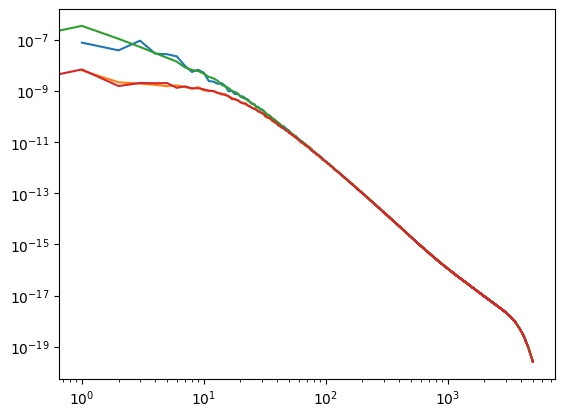

In [41]:
#NO NORMALIZATION

meana, meanb = np.loadtxt("mean_a.txt"), np.loadtxt("mean_b.txt")
plt.plot(meana*WFth10**2)
plt.plot(meanb*WFth10**2)

itr = -1


A = autos_split[0][itr]
A_d = autos_split_d[0][itr]
plt.loglog(A) #with rotation effect
plt.loglog(A_d) #without rotation effect

#difference = (A-A_d)

#plt.loglog(difference)

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_13388/592582045.py:1: RuntimeWarning: divide by zero encountered in power
  plt.loglog((A-A_d)*WFth10**-2) #with rotation effect
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_13388/592582045.py:1: RuntimeWarning: invalid value encountered in multiply
  plt.loglog((A-A_d)*WFth10**-2) #with rotation effect


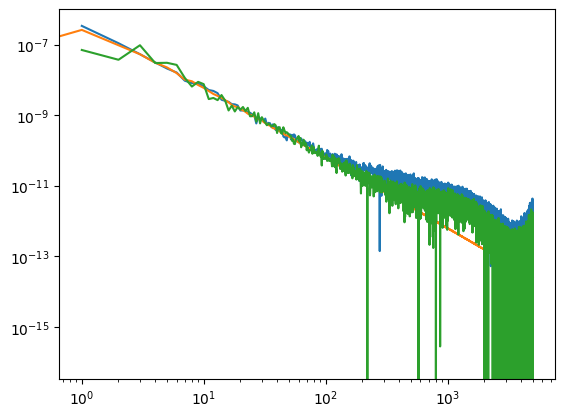

In [42]:
plt.loglog((A-A_d)*WFth10**-2) #with rotation effect
plt.plot(inputs[0])
plt.plot((meana-meanb))

In [18]:
n1aa_der = np.loadtxt("n1_aa_derot.txt") #only in the signal, not in the filters
n1aa = np.loadtxt("../data/plots/noise_curves/noise_biases_cmb_s4/n1_aa_itr_10.txt") #only delensing

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_13388/2083879969.py:2: RuntimeWarning: invalid value encountered in divide
  WF = cross_split[0][itr]/inputs[0]
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_13388/2083879969.py:3: RuntimeWarning: invalid value encountered in divide
  WF_d = cross_split_d[0][itr]/inputs_d[0]
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_13388/2083879969.py:5: RuntimeWarning: invalid value encountered in divide
  WFl = cross_lensed_split[0][itr]/inputs[0]
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_13388/2083879969.py:16: RuntimeWarning: divide by zero encountered in power
  A = autos_split[0][itr]*WF**-2
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_13388/2083879969.py:16: RuntimeWarning: invalid value encountered in multiply
  A = autos_split[0][itr]*WF**-2
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_13388/2083879969.py:17: RuntimeWarning: divide by zero encountered in power


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/lenscarf/lib/python3.10/site-packages/matplotlib/pyplot.py'>

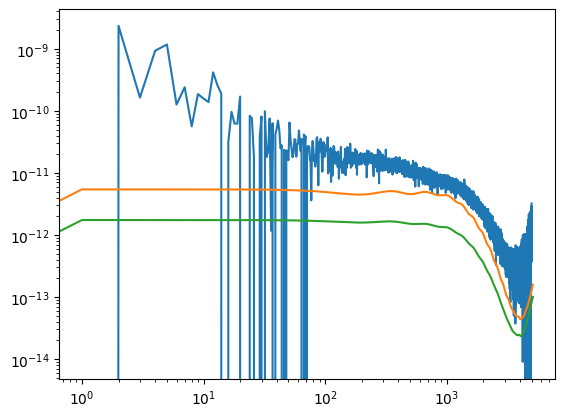

In [26]:
itr = -1
WF = cross_split[0][itr]/inputs[0]
WF_d = cross_split_d[0][itr]/inputs_d[0]

WFl = cross_lensed_split[0][itr]/inputs[0]
#WF_d = cross_lensed_split_d[0][itr]/inputs_d[0]

#plt.loglog(WF)
#plt.plot(WF_d)

WFth10 = cls_alpha/(cls_alpha+ngg_10)
WFth10 = WFth10[:5001]
WF = WFth10
WF_d = WF #WF_d no rotation

A = autos_split[0][itr]*WF**-2
A_d = autos_split_d[0][itr]*WF_d**-2

plt.loglog(A-A_d-inputs[0])
#el, x = decorator(A_d)
#plt.loglog(el, x)
#el, xNoise = decorator(A-inputs[0])
#plt.loglog(el, xNoise)
#plt.plot(ngg_10)
#plt.plot(el, -(x-xNoise))

plt.plot(n1aa)
plt.plot(n1aa_der)

"""n1_ap = np.loadtxt(f"noise_biases/n1_ap_itr_10.txt")
plt.plot(n1_ap, lw = 2)

n1_aa = np.loadtxt(f"noise_biases/n1_aa_itr_10.txt")
plt.plot(n1_aa, lw = 1)"""

plt

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_13388/555012254.py:2: RuntimeWarning: invalid value encountered in divide
  WF = cross_split[0][itr]/inputs[0]
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_13388/555012254.py:3: RuntimeWarning: invalid value encountered in divide
  WF_d = cross_split_d[0][itr]/inputs_d[0]
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_13388/555012254.py:5: RuntimeWarning: invalid value encountered in divide
  WF = cross_lensed_split[0][itr]/inputs[0]
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_13388/555012254.py:6: RuntimeWarning: invalid value encountered in divide
  WF_d = cross_lensed_split_d[0][itr]/inputs_d[0]


'n1_aa = np.loadtxt(f"noise_biases/n1_ap_itr_10.txt")\nplt.plot(n1_aa, lw = 4)'

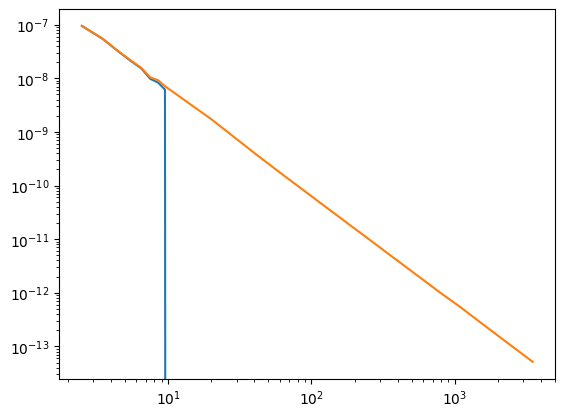

In [13]:
itr = -1
WF = cross_split[0][itr]/inputs[0]
WF_d = cross_split_d[0][itr]/inputs_d[0]

WF = cross_lensed_split[0][itr]/inputs[0]
WF_d = cross_lensed_split_d[0][itr]/inputs_d[0]

#plt.loglog(WF)
#plt.plot(WF_d)

WF_d = WF #WF_d no rotation

A = autos_split[0][itr]*WF**-2
A_d = autos_split_d[0][itr]*WF_d**-2
#plt.loglog(A)

difference = (A-A_d)#with rotation minus without rotation

#plt.loglog(difference)
plt.loglog(*decorator(difference))

plt.plot(*decorator(inputs[0]))

difference = (A-A_d-inputs[0])#with rotation minus without rotation
plt.loglog(*decorator(difference), ls = "--")

"""n1_aa = np.loadtxt(f"noise_biases/n1_aa_itr_10.txt")
plt.plot(n1_aa, lw = 2)
n1_aa = np.loadtxt(f"noise_biases/n1_aa_QE.txt")
plt.plot(n1_aa, lw = 2, ls = "--")

n1_aa = np.loadtxt(f"noise_biases/n1_ap_itr_10.txt")
plt.plot(n1_aa, lw = 4)
n1_aa = np.loadtxt(f"noise_biases/n1_ap_QE.txt")
plt.plot(n1_aa, lw = 4, ls = "--")"""

"""n1_aa = np.loadtxt(f"noise_biases/n1_ap_itr_10.txt")
plt.plot(n1_aa, lw = 4)"""


## Studying WF

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_98838/1447551766.py:9: RuntimeWarning: divide by zero encountered in divide
  cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(ns)


/Volumes/OmarFiles/joint_map_outputs//total_qe_it_cross_lensed_p_p_apo_new_official_check_factor_2_apo_new_0_63_15.npy


/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_98838/1447551766.py:30: RuntimeWarning: invalid value encountered in divide
  WF = cross_split[ii][itr]/inputs[ii]
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_98838/1447551766.py:31: RuntimeWarning: invalid value encountered in divide
  WF_lensed = cross_lensed_split[ii][itr]/inputs[ii]


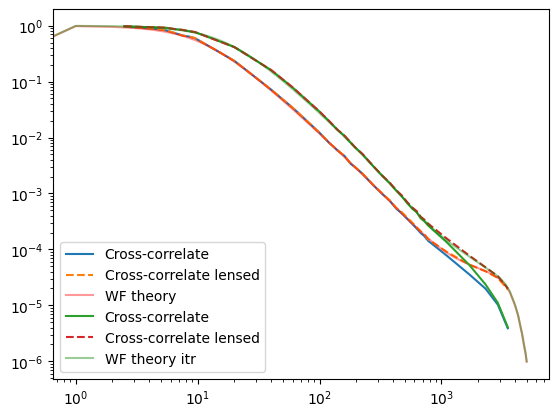

In [14]:
config_paths = ["official_check_factor_2"] #["official"] #["official_so_a_disabled"]#["official"] #["official_a_disabled"]#, "official"]#, "official_a_disabled", "official_a_disabled_scale_dependent"]#,  "config_full_no_alpha_no_curl_lensing_cmb_s4"]
config_paths = [f"configs/{config}.yaml" for config in config_paths]

ii = 0

ell = np.arange(0, 5001)
ACB = 7
ns = 1.
cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(ns)
cls_alpha[0] = 0
ngg = np.loadtxt(f"n_gg_a_QE.txt")[:5001]
ngg_10 = np.loadtxt(f"ngg_a_itr_10.txt")[:5001]
WFth = cls_alpha/(cls_alpha+ngg)
WFth10 = cls_alpha/(cls_alpha+ngg_10)

for j, config_path in enumerate(config_paths):
    selected, autoits, crossits, auto_input_its, _, _, crossits_lensed = process_config_npy(config_path)

    autos = autoits.mean(axis = 0)
    crosses = crossits.mean(axis = 0)
    crosses_lensed = crossits_lensed.mean(axis = 0)

    inputs = auto_input_its.mean(axis = 0)

    autos_split = np.split(autos, len(selected), axis = -1)
    cross_split = np.split(crosses, len(selected), axis = -1)
    cross_lensed_split = np.split(crosses_lensed, len(selected), axis = -1)

    for itr in [0, 10]:
        WF = cross_split[ii][itr]/inputs[ii]
        WF_lensed = cross_lensed_split[ii][itr]/inputs[ii]
        np.save(f"WFS_{itr}.txt", np.c_[WF, WF_lensed])

        #plt.loglog(WF, ls = "-" if j == 0 else "--")
        el, WF = decorator(WF)
        plt.loglog(el, WF, ls = "-" if j == 0 else "--", label = "Cross-correlate")

        el, WF_lensed = decorator(WF_lensed)
        plt.loglog(el, WF_lensed, ls = "--" if j == 0 else "--", label = "Cross-correlate lensed")

        if itr == 0:
            plt.loglog(WFth, color = "red", alpha = 0.4, label = "WF theory")
        else:
            WFth10 = cls_alpha/(cls_alpha+ngg_10)
            plt.loglog(WFth10, color = "green", alpha = 0.4, label = "WF theory itr")

    plt.legend()
    plt.yscale("log")


/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_98838/2667755734.py:1: RuntimeWarning: invalid value encountered in divide
  rho = (cross_split[ii][itr]/np.sqrt(inputs[ii]*autos_split[ii][itr]))


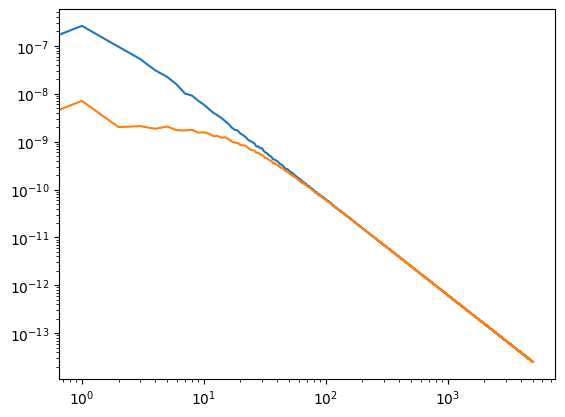

In [15]:
rho = (cross_split[ii][itr]/np.sqrt(inputs[ii]*autos_split[ii][itr]))
rho2 = rho**2
cls_alpha_residual = (1-rho2)*inputs[ii]
cls_alpha_residual = np.nan_to_num(cls_alpha_residual)

plt.loglog(inputs[ii])
plt.loglog(cls_alpha_residual)

In [17]:
np.savetxt("cls_alpha_residual.txt", cls_alpha_residual)

In [13]:
"""
Get noise biases for 
"""

from os.path import join as opj
import os
from plancklens import utils
from plancklens.helpers import mpi
import numpy as np
import healpy as hp
from plancklens.n1 import n1
from plancklens import nhl, n0s, qresp

def camb_clfile_gradient(fname, lmax=None):
    """CAMB spectra (lenspotentialCls, lensedCls or tensCls types) returned as a dict of numpy arrays.
    Args:
        fname (str): path to CAMB output file
        lmax (int, optional): outputs cls truncated at this multipole.
    """
    cols = np.loadtxt(fname).transpose()
    ell = np.int_(cols[0])
    if lmax is None: lmax = ell[-1]
    assert ell[-1] >= lmax, (ell[-1], lmax)
    cls = {k : np.zeros(lmax + 1, dtype=float) for k in ['tt', 'ee', 'bb', 'te']}
    w = ell * (ell + 1) / (2. * np.pi)  # weights in output file
    idc = np.where(ell <= lmax) if lmax is not None else np.arange(len(ell), dtype=int)
    for i, k in enumerate(['tt', 'ee', 'bb', 'te']):
        cls[k][ell[idc]] = cols[i + 1][idc] / w[idc]
    return cls

cls_path = opj(os.environ['HOME'], 'fgcmblensing', 'input', 'giulio')
#cls_path = opj("/Users/omard/Downloads/", 'giulio')
cls_unl = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lenspotentialCls.dat'))
cls_len = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lensedCls.dat'))
cls_grad = camb_clfile_gradient(opj(cls_path, 'lensedCMB_dmn1_lensedgradCls.dat'))
cls_rot = np.loadtxt(opj(cls_path, 'new_lensedCMB_dmn1_field_rotation_power.dat')).T[1]

SO_case = False
nlev_t = 1. if not SO_case else 6.
nlev_p = nlev_t*np.sqrt(2)
beam_fwhm = 1. if SO_case else 1.4
cls_unl_fid = cls_unl
lmin_cmb = 30
lmin_blm, lmin_elm, lmin_tlm = lmin_cmb, lmin_cmb, lmin_cmb
lmax_cmb = 4000
itermax = 1
ret_curl = True

lmax_qlm = 5120

lt, le, lb = (np.arange(lmax_cmb + 1) >= lmin_tlm), (np.arange(lmax_cmb + 1) >= lmin_elm), (np.arange(lmax_cmb + 1) >= lmin_blm)

transf = hp.gauss_beam(beam_fwhm / 180 / 60 * np.pi, lmax=lmax_cmb)
ftl = utils.cli(cls_len['tt'][:lmax_cmb + 1] + (nlev_t / 60. / 180. * np.pi) ** 2 / transf ** 2)*lt# isotropic approximation to the  T filtering, must match that applied to the data
fel = utils.cli(cls_len['ee'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*le # isotropic approximation to the E filtering
fbl = utils.cli(cls_len['bb'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*lb # isotropic approximation to the P filtering
fals = {'tt':ftl, 'ee':fel, 'bb':fbl}
dat_cls = {'tt':(cls_len['tt'][:lmax_cmb + 1] + (nlev_t / 60. / 180. * np.pi) ** 2 / transf ** 2)*lt,
            'ee': (cls_len['ee'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*le,
               'bb': (cls_len['bb'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*lb}

cls_ivfs_arr = utils.cls_dot([fals, dat_cls, fals])

cls_ivfs = dict()
for i, a in enumerate(['t', 'e', 'b']):
    for j, b in enumerate(['t', 'e', 'b'][i:]):
        if np.any(cls_ivfs_arr[i, j + i]):
            cls_ivfs[a + b] = cls_ivfs_arr[i, j + i]


nggs = {}
r_ggs = {}
for source in ["p", "a"]:
    qe_key = f"{source}_p"

    GG_N0, CC_N0 = nhl.get_nhl(qe_key, qe_key, cls_len, cls_ivfs, lmax_cmb, lmax_cmb, lmax_out = lmax_qlm)[0:2]

    r_gg_fid, r_cc_fid = qresp.get_response(qe_key, lmax_cmb, source, cls_len, cls_grad, fals, lmax_qlm = lmax_qlm)[0:2]

    n_gg = GG_N0 * utils.cli(r_gg_fid ** 2)

    nggs[source] = n_gg
    r_ggs[source] = r_gg_fid

In [14]:
ns = 1
ACB = 7
ell = np.arange(0, len(cls_unl["tt"])+1)
cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**ns
cls_alpha[0] = 0

cls_unl["aa"] = cls_alpha

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_97285/2430758186.py:4: RuntimeWarning: divide by zero encountered in divide
  cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**ns


In [15]:
cls_alpha_residual = (1-rho2)*inputs[ii]
cls_alpha_residual = np.nan_to_num(cls_alpha_residual)
cls_unl["aa"] = cls_alpha_residual[:cls_alpha.size]

In [16]:
qe_key = "a_p"

dir = "s4data/"

it = 10
fal, dat_delcls, cls_w, cls_f = np.load(f"{dir}fal_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}dat_delcls_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}cls_w_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}cls_f_{it}.npy", allow_pickle=True).take(0)
cls_ivfs_arr = utils.cls_dot([fal, dat_delcls, fal])
cls_ivfs = dict()
for i, a in enumerate(['t', 'e', 'b']):
    for j, b in enumerate(['t', 'e', 'b'][i:]):
        if np.any(cls_ivfs_arr[i, j + i]):
            cls_ivfs[a + b] = cls_ivfs_arr[i, j + i]
n_gg = nhl.get_nhl(qe_key, qe_key, cls_w, cls_ivfs, lmax_cmb, lmax_cmb, lmax_out=lmax_qlm)[0]
r_gg_true = qresp.get_response(qe_key, lmax_cmb, source, cls_w, cls_f, fal, lmax_qlm=lmax_qlm)[0]
N0_unbiased = n_gg * utils.cli(r_gg_true ** 2)  # N0 of QE estimator after rescaling by Rfid / Rtrue to make it unbiased

print("Read", f"{dir}fid_delcls_10.npy")
fid_delcls_10 = np.load(f"{dir}fid_delcls_10.npy", allow_pickle=True)

lib_dir = f'./n1s_aa_itr_10_rho2'
n1lib = n1.library_n1(lib_dir, cls_w['tt'], cls_w['te'], cls_w['ee'], lmaxphi=2500, dL=10, lps=None)
#n1_ap = n1lib.get_n1('a_p', 'p', fid_delcls_10[-1]['pp'], fal["ee"]*1e-30, fal["ee"], fal["bb"], lmax_qlm)*utils.cli(r_gg_true ** 2)
n1_aa = n1lib.get_n1('a_p', 'a', cls_unl['aa'], fal["ee"]*1e-30, fal["ee"], fal["bb"], lmax_qlm)*utils.cli(r_gg_true ** 2)

Read s4data/fid_delcls_10.npy
n1: rank 0 doing L 1 kA aee kB aee kind a


: 

: 

## Randomized noise

In [184]:
config_paths = ["official", "official_a_disabled", "official_so_a_disabled", "official", "alpha_after_lensing_sims", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation_no_curl_est"]#,  "config_full_no_alpha_no_curl_lensing_cmb_s4"]


#config_paths = config_paths[1:]
config_paths = [f"configs/{config}.yaml" for config in config_paths]

socase = "so" in config_paths[0]

label = "so" if socase else "s4"
dir = "sodata/" if socase else ""
direc = "_so" if socase else ""

ngg = np.loadtxt(f"{dir}n_gg_a_QE.txt")[:5001]

ngg_10 = np.loadtxt(f"{dir}ngg_a_itr_10.txt")[:5001]

n1_ap = np.loadtxt(f"/Users/omard/Documents/projects/jointmap/data/plots/noise_curves/noise_biases_cmb_s4/n1_ap_QE.txt")[:5001]
n1_aa = np.loadtxt(f"/Users/omard/Documents/projects/jointmap/data/plots/noise_curves/noise_biases_cmb_s4/n1_aa_QE.txt")[:5001]

n1_ap_10 = np.loadtxt(f"/Users/omard/Documents/projects/jointmap/data/plots/noise_curves/noise_biases_cmb_s4/n1_ap_itr_10.txt")[:5001]
n1_aa_10 = np.loadtxt(f"/Users/omard/Documents/projects/jointmap/data/plots/noise_curves/noise_biases_cmb_s4/n1_aa_itr_10.txt")[:5001]

#ngg_unl = np.loadtxt(f"{dir}ngg_a_itr_unl.txt")[:5001]

In [14]:
config_paths = ["official_a_disabled", "official_a_disabled", "official_so_a_disabled", "official", "alpha_after_lensing_sims", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation_no_curl_est"]#,  "config_full_no_alpha_no_curl_lensing_cmb_s4"]
config_paths = [f"configs/{config}.yaml" for config in config_paths]

selected, autoits, crossits, auto_input_its, _, _, crossits_lensed = process_config_npy(config_paths[0])


autos = autoits.mean(axis = 0)
crosses = crossits.mean(axis = 0)
crosses_lensed = crossits_lensed.mean(axis = 0)
inputs = auto_input_its.mean(axis = 0)

stdautos = autoits.std(axis = 0)

autos_split_full = np.split(autos, len(selected), axis = -1)
cross_split = np.split(crosses, len(selected), axis = -1)
crosses_lensed_split =  np.split(crosses_lensed, len(selected), axis = -1)

WFs_full = crosses_lensed/np.concatenate(inputs, axis = 0)#[, :]
WFs_full = np.split(WFs_full, 3, axis = -1)

Nblock = 64
autoits_block1 = autoits[:Nblock, ...]
crossits_block1 = crossits[:Nblock, ...]

autoits_block2 = autoits[Nblock:, ...]
crossits_block2 = crossits[Nblock:, ...]
autoits_block2m = autoits_block2.mean(axis = 0)
crossits_block2m = crossits_block2.mean(axis = 0)

autoits_block2_split = np.split(autoits_block2m, len(selected), axis = -1)
crossits_block2_split = np.split(crossits_block2m, len(selected), axis = -1)

autos = autoits_block1.mean(axis = 0)
crosses = crossits_block1.mean(axis = 0)
inputs = auto_input_its.mean(axis = 0)

stdautos = autoits.std(axis = 0)

autos_split = np.split(autos, len(selected), axis = -1)
cross_split = np.split(crosses, len(selected), axis = -1)

WFs = crosses/np.concatenate(inputs, axis = 0)#[, :]
WFs = np.split(WFs, 3, axis = -1)

itr_ = 10
N1plot = np.loadtxt(f"N1s_{itr_}.txt")
N0plot = np.loadtxt(f"N0s_{itr_}.txt")

/scratch/snx3000/odarwish/joint_map_outputs//total_qe_it_cross_lensed_p_p_apo_new_official_a_disabled_apo_new_0_127_20.npy


/tmp/ipykernel_22286/1537021908.py:18: RuntimeWarning: invalid value encountered in divide
  WFs_full = crosses_lensed/np.concatenate(inputs, axis = 0)#[, :]
/tmp/ipykernel_22286/1537021908.py:42: RuntimeWarning: invalid value encountered in divide
  WFs = crosses/np.concatenate(inputs, axis = 0)#[, :]


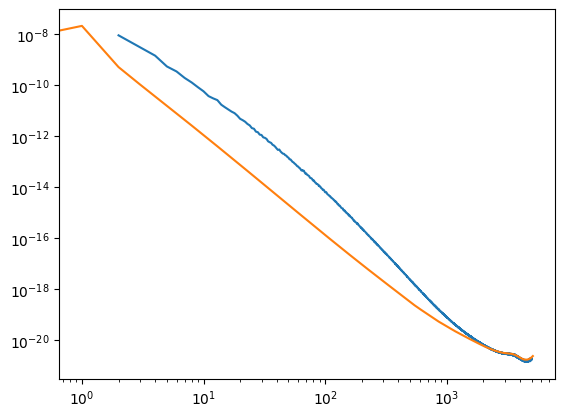

In [15]:
source = 1
itr = -1
plt.loglog(autoits_block2_split[source][itr]*WFs[source][itr]**-2.)
plt.plot(N0plot)

In [21]:
ngg_a_itr_unl = np.loadtxt("ngg_a_itr_unl.txt")

In [76]:
dirij = "/Users/omard/Downloads/"

idxs = range(1)
ii = 0

tv = []
zv = []
wv = []
xv = []
av = []
bv = []
cv = []

coadd = []

itrmax = 15

for idx in idxs:
    plm_ij = np.load(f"{dirij}/plm_N0p{itrmax:03}_i_j_sim{idx:04}.npy")
    plm_ji = np.load(f"{dirij}/plm_N0p{itrmax:03}_j_i_sim{idx:04}.npy")

    """plm_ij = np.split(plm_ij, 3)[ii]
    plm_ji = np.split(plm_ji, 3)[ii]"""

    t = hp.alm2cl(plm_ij, plm_ji)+hp.alm2cl(plm_ij)
    tv.append(t)
    z = hp.alm2cl((plm_ji+plm_ij)*0.5)
    zv.append(z)
    w = hp.alm2cl(plm_ji)
    wv.append(w)
    x = hp.alm2cl(plm_ij)
    xv.append(x)

    plm_ij_coadd = (plm_ij+plm_ji)/2
    coadd.append(hp.alm2cl(plm_ij_coadd))

am = np.mean(av, axis = 0)
bm = np.mean(bv, axis = 0)
cm = np.mean(cv, axis = 0)
tm = np.mean(tv, axis = 0)
zm = np.mean(zv, axis = 0)
wm = np.mean(wv, axis = 0)
xm = np.mean(xv, axis = 0)
coadd = np.mean(coadd, axis = 0)


/opt/homebrew/Caskroom/miniforge/base/envs/lenscarf/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/envs/lenscarf/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [124]:
dirij = "/Users/omard/Downloads/"
dirij_old = "/Users/omard/Downloads/old/"

In [129]:
plm_ij = np.load(f"{dirij}/plm_N0p{itrmax:03}_i_j_sim{0:04} (1).npy")
plm_ji = np.load(f"{dirij}/plm_N0p{itrmax:03}_j_i_sim{0:04} (1).npy")

plm_ij_1 = np.load(f"{dirij}/plm_N0p{itrmax:03}_i_j_sim{0:04}.npy")
plm_ji_1 = np.load(f"{dirij}/plm_N0p{itrmax:03}_j_i_sim{0:04}.npy")

plm_ij_2 = np.load(f"{dirij}/plm_N0p{itrmax:03}_i_j_sim{0:04} (2).npy")
plm_ji_2 = np.load(f"{dirij}/plm_N0p{itrmax:03}_j_i_sim{0:04} (2).npy")

In [130]:
plm_ij_o = np.load(f"{dirij_old}/plm_N0p{itrmax:03}_i_j_sim{0:04}.npy")
plm_ji_o = np.load(f"{dirij_old}/plm_N0p{itrmax:03}_j_i_sim{0:04}.npy")

plm_ij_1_o = np.load(f"{dirij_old}/plm_N0p{itrmax:03}_i_j_sim{1:04}.npy")
plm_ji_1_o = np.load(f"{dirij_old}/plm_N0p{itrmax:03}_j_i_sim{1:04}.npy")

In [85]:
cl = hp.alm2cl((plm_ij+plm_ji+plm_ij_1+plm_ji_1)/4)

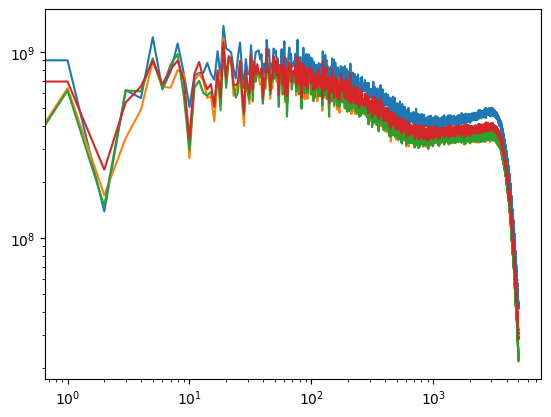

In [110]:
plt.loglog(hp.alm2cl(plm_ij))

plt.loglog(hp.alm2cl(plm_ij,plm_ij_1))

plt.loglog(hp.alm2cl(plm_ij,plm_ij_2))

p = (plm_ij+plm_ij_1+plm_ij_2)/3
plt.plot(hp.alm2cl(p))

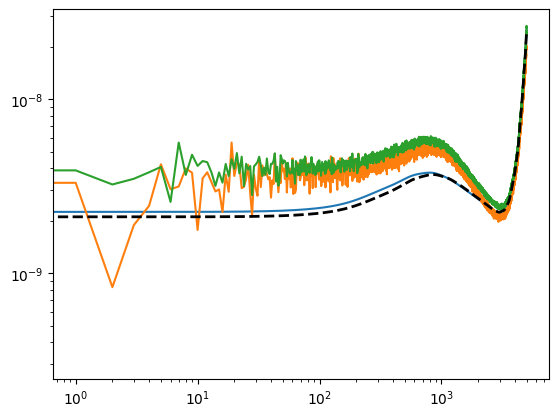

In [137]:
#cl = 4*hp.alm2cl(plm_id)-2*hp.alm2cl(plm_ij)
#plt.loglog((4*hp.alm2cl(plm_coadd)-2*hp.alm2cl(plm_ij_coadd))*(N0**2)[:5001])

N0 = ngg_10 if ii == 0 else N0plot

#plt.loglog((hp.alm2cl(plm_ij, plm_ji))*(N0**2)[:5001])
ff = (N0**2)[:5001]

plt.loglog(N0+n1_ap_10+n1_aa_10)
#plt.loglog(coadd*ff)

#plt.loglog(hp.alm2cl(plm_ij,plm_ij_1)*ff)
plt.loglog(hp.alm2cl((plm_ij+plm_ij_1)*0.5)*ff)
c1 = (plm_ij+plm_ji)*0.5
c2 = (plm_ij_1+plm_ji_1)*0.5
#plt.loglog(hp.alm2cl(p)*ff)

xxmean = hp.alm2cl(plm_ij, plm_ji)+hp.alm2cl(plm_ij_1, plm_ji_1)+hp.alm2cl(plm_ij_2, plm_ji_2)
xxmean /= 3
#plt.loglog(xxmean*ff)


xxmean = hp.alm2cl((plm_ij_o+plm_ji_o)/2)+hp.alm2cl((plm_ij_1_o+plm_ji_1_o)/2)
xxmean /= 2
plt.loglog(2*xxmean*ff)


#plt.plot(2*cl*ff)

#plt.plot(n1_ap+N0, ls = "--")
#plt.loglog(clcoadd*(N0**2)[:5001])

#plt.loglog(tm*(N0**2)[:5001])
#plt.loglog(zm*(N0**2)[:5001])
#plt.loglog(wm*(N0**2)[:5001])
#plt.loglog(xm*(N0**2)[:5001])
#plt.loglog(am*(N0**2)[:5001])
#plt.loglog(bm*(N0**2)[:5001])
#plt.loglog(cm*(N0**2)[:5001])
plt.plot(N0, lw = 2, color = "black", ls = "--")

#plt.loglog(*decorator(hp.alm2cl(plm_ji, plm_ij)*N0[:5001]**2))

source = ii
#plt.loglog(autoits_block2_split[source][itr]*WFs_full[source][itr]**-2.)


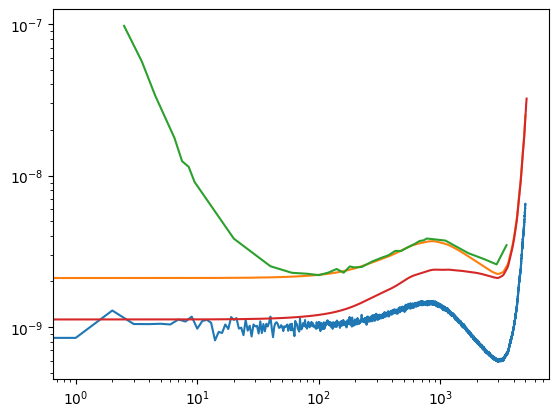

In [77]:
NN = 5
dirij = "/users/odarwish/scratch/JOINTRECONSTRUCTION/apo_new_version_apo_new_official_recs/p_p_sim0000apo_new_official/"
prand = ((np.load(f"{dirij}/plm_N0p020_i_j_sim{idx:04}.npy")+np.load(f"{dirij}/plm_N0p020_j_i_sim{idx:04}.npy")) for idx in range(NN))
ii = 0
cl = np.sum(np.array(list(map(lambda x: hp.alm2cl(np.split(x, 3)[ii]).squeeze(), prand))), axis = 0)/NN

if ii == 0:
    plt.loglog(0.5*cl*ngg_10**2.)
    plt.plot(ngg_10)

    source = ii
    itr = -1

    
    #plt.plot(autoits_block2_split[source][itr]*WFs[source][itr]**-2.)


    plt.plot(*decorator(autos_split_full[source][itr]*WFs_full[source][itr]**-2.))

    plt.plot(ngg_a_itr_unl)
else:
    N0plot = np.loadtxt(f"N0s_10.txt")
    plt.loglog(0.5*cl*(N0plot**2)[:5001])
    plt.plot(N0plot)
    #plt.plot(autoits_block2_split[1][-1]*WFs[1][itr]**-2.)

## Noise improvements plots

/Volumes/OmarFiles/joint_map_outputs//total_qe_it_cross_lensed_p_p_apo_new_official_check_factor_2_apo_new_0_63_15.npy


/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_2121/852745799.py:55: RuntimeWarning: invalid value encountered in divide
  WF = cross_split[i][itr]/inputs[i]


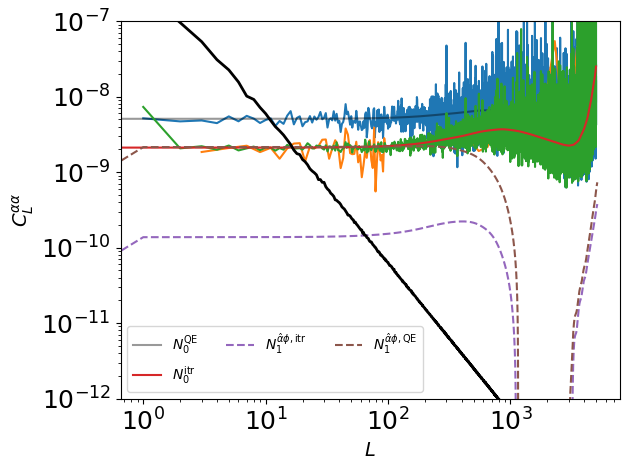

In [300]:
selected = ['a', 'p', 'o']

invWFs = {}

config_paths = ["official_check_factor_2", "official_check_factor_2", "official_a_disabled", "official_a_disabled", "official_so_a_disabled", "official", "alpha_after_lensing_sims", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation_no_curl_est"]#,  "config_full_no_alpha_no_curl_lensing_cmb_s4"]
config_paths = [f"configs/{config}.yaml" for config in config_paths]


bin_edges_B = np.arange(2, 100, 1)
bin_edges = np.concatenate([bin_edges_B, np.arange(100, 800, 100), np.arange(800, 4000, 600)])


bin_edges_B = np.arange(2, 100, 2)
bin_edges = np.concatenate([bin_edges_B, np.arange(100, 800, 100), np.arange(800, 4000, 600)])

decorator = lambda x: bin_theory(x, bin_edges)

ngg = np.loadtxt(f"{dir}n_gg_a_QE.txt")[:5001]

ngg_10 = np.loadtxt(f"{dir}ngg_a_itr_10.txt")[:5001]

n1_ap = np.loadtxt(f"/Users/omard/Documents/projects/jointmap/data/plots/noise_curves/noise_biases_cmb_s4/n1_ap_QE.txt")[:5001]
n1_ap_10 = np.loadtxt(f"/Users/omard/Documents/projects/jointmap/data/plots/noise_curves/noise_biases_cmb_s4/n1_ap_itr_10.txt")[:5001]
n1_aa_10 = np.loadtxt(f"/Users/omard/Documents/projects/jointmap/data/plots/noise_curves/noise_biases_cmb_s4/n1_aa_itr_10.txt")[:5001]


directory = "../data/plots/plot_alpha_data/"
N0_rand = np.loadtxt(directory+"N0_rand.txt")

for i, s in enumerate(selected[:1]):
    for j, config_path in enumerate(config_paths[:1]):
        selected, autoits, crossits, auto_input_its, _, _, crossits_lensed = process_config_npy(config_path)

        autos = autoits.mean(axis = 0)
        crosses = crossits.mean(axis = 0)
        crosses_lensed = crossits_lensed.mean(axis = 0)
        inputs = auto_input_its.mean(axis = 0)

        stdautos = autoits.std(axis = 0)

        autos_split = np.split(autos, len(selected), axis = -1)
        cross_split = np.split(crosses, len(selected), axis = -1)
        cross_lensed_split = np.split(crosses_lensed, len(selected), axis = -1)
        cross_split = cross_lensed_split

        """plt.loglog(cross_split[0][0]*WFth**-1.)

        plt.loglog(cross_split[0][-1]*WFth10**-1.)

        plt.loglog(inputs[0])
        plt.show()"""

        for itr in [0, autos.shape[0]-1]:
    
            WF = cross_split[i][itr]/inputs[i]
            el, WF_ = decorator_WF(WF)
            import scipy.interpolate
            WFf = scipy.interpolate.interp1d(el, WF_, kind = "linear", fill_value = "extrapolate")
            ls = np.arange(100, 5001)
            WFinterp = WFf(ls)
            WFother = WF.copy()
            WFother[100:] = WFinterp
            
            if itr == 0:
                WFQE = WF
            invWF = WF**-1.
            if j == 0:
                invWFs[s] = invWF

            #xx = autos_split[i][itr]*invWFs[s]**2.-inputs[i]

            #WF = WFth if itr == 0 else WFth10

            if i == 1:
                itr_ = 10 if itr in [15, 20] else itr
                N1plot = np.loadtxt(f"N1s_{itr_}.txt")
                N0plot = np.loadtxt(f"N0s_{itr_}.txt")
                plt.loglog(N1plot, ls = "--")
                plt.plot(N0plot, ls = "--")
                if itr == 20:
                    xx = autos_split[i][itr]*WF**-2.-inputs[i]-N0plot[:5001]
                    plt.loglog(xx)


            if itr == 0:

                xx = autos_split[i][itr]*WF**-2.-inputs[i]-n1_ap[:5001]*(i == 0)
                plt.loglog(xx)

                #n1_aa = np.loadtxt(f"noise_biases{direc}/n1_aa_QE.txt")
                #plt.loglog(n1_aa, ls = "--")
                el, x = decorator(xx)
                
                #plt.plot(autos_split[i][itr]*WFth**-2.-nggs["a"][:5001]-inputs[i], color = "green")
               # plt.plot(autos_split[i][itr]*WFth**-2., color = "green")
                #plt.plot(el, x, lw = 2, label = r"$C_L^{\hat{\alpha}^{\mathrm{QE}}\hat{\alpha}^{\mathrm{QE}}}-C_L^{\alpha\alpha}-N_1^{\hat{\alpha}\phi}$")

                xx = autos_split[i][itr]*WF**-2.-inputs[i]-ngg[:5001]
                el, x = decorator(xx)
                plt.plot(el, x)

                if i == 0:
                    plt.plot(ngg, color = "black", alpha = 0.4, label = r"$N_0^{\mathrm{QE}}$")
                
                #el, xy = decorator(autos_split[i][itr]*invWFs[s]**2.)
                #el, xy = decorator(autos_split[i][itr]*WFth**-2.)
                #plt.plot(el, xy, label = "WF normalized")
                #np.savetxt("x.txt", np.c_[el, xy])

                
                #el, xy = decorator(qe_alpha)
                #plt.plot(el, xy, ls = "--", label = "QE normalized")

            else:

                WFnorm = WFth10
                #WFnorm = WFother
                WFnorm = WF
                
                xx = autos_split[i][itr]*WFnorm**-2.-inputs[i]
                plt.plot(xx)
                el, x = decorator(xx)
                #plt.plot(el, x, color = "brown", label = r"$C_L^{\hat{\alpha}^{\mathrm{QE}}\hat{\alpha}^{\mathrm{QE}}}-C_L^{\alpha\alpha}$")
                #el, x = decorator(autos_split[i][itr]*WF**-2.)
                #plt.plot(el, x, color = "red", ls = "--")
                if i == 0:
                    plt.plot(ngg_10, label = r"$N_0^{\mathrm{itr}}$")

                if i == 0:
                    xx = autos_split[i][itr]*WFnorm**-2.-inputs[i]-ngg_10[:5001]
                    el, x = decorator(autos_split[i][itr]*WFnorm**-2.-inputs[i]-ngg_10[:5001])
                    #plt.loglog(xx)
                    #plt.plot(el, x, marker = "o")

                if i == 0:
                    n1_ap = np.loadtxt(f"/Users/omard/Documents/projects/jointmap/data/plots/noise_curves/noise_biases_cmb_s4/n1_ap_itr_10.txt")
                    plt.loglog(n1_ap, label = r"$N_1^{\hat{\alpha}\phi, \mathrm{itr}}}$", ls = "--")

                #n1_aa = np.loadtxt(f"noise_biases{direc}/n1_aa_itr_10.txt")
                #plt.loglog(n1_aa, ls = ":")

    
        if i == 0:
            n1_ap = np.loadtxt(f"/Users/omard/Documents/projects/jointmap/data/plots/noise_curves/noise_biases_cmb_s4/n1_ap_QE.txt")
            plt.loglog(n1_ap, label = r"$N_1^{\hat{\alpha}\phi, \mathrm{QE}}}$", ls = "--")

        plt.plot(inputs[i], color = "black", lw = 2)#, label = r"$C_L^{\alpha\alpha}$")
        #plt.plot(nggs[s], lw = 2)
        #plt.plot(n0_bb)
        #plt.title(s)
        #print(a)
        #plt.xlim(5, 2000)
        #plt.savefig("")
        plt.yticks(fontsize = 18)
        
        plt.xticks(fontsize = 18)
        plt.xlabel(r"$L$", fontsize = 14)
    if s == "a":
        plt.ylabel(r"$C_L^{\alpha\alpha}$", fontsize = 14)
        if socase:
            #plt.ylim(1e-8, 5e-7)
            pass
        else:
            pass
        plt.ylim(1e-12, 1e-7)
        plt.tight_layout()
        plt.xscale("log")
        plt.yscale("log")
        #plt.xlim(3, 1000)
        plt.legend(ncol = 3, fontsize = 10)
        #plt.savefig(f"/users/odarwish/JointCMBiterative/figures/examples/alpha_improvements_{label}.pdf", dpi = 300)
    plt.show()

/Volumes/OmarFiles/joint_map_outputs//total_qe_it_cross_lensed_p_p_apo_new_official_check_factor_2_apo_new_0_63_15.npy


/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_2121/2084400679.py:55: RuntimeWarning: invalid value encountered in divide
  WF = cross_split[i][itr]/inputs[i]
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_2121/2084400679.py:98: RuntimeWarning: divide by zero encountered in power
  xx = autoits[0][itr][:5001]*WFth**-2.-auto_input_its[0][i]-ngg[:5001]
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_2121/2084400679.py:98: RuntimeWarning: invalid value encountered in multiply
  xx = autoits[0][itr][:5001]*WFth**-2.-auto_input_its[0][i]-ngg[:5001]
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_2121/2084400679.py:121: RuntimeWarning: divide by zero encountered in power
  xx = autoits[0][itr][:5001]*WFnorm**-2.-auto_input_its[0][i]
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_2121/2084400679.py:121: RuntimeWarning: invalid value encountered in multiply
  xx = autoits[0][itr][:5001]*WFnorm**-2.-auto_input_its[0][i]
/var/folders/5s/m

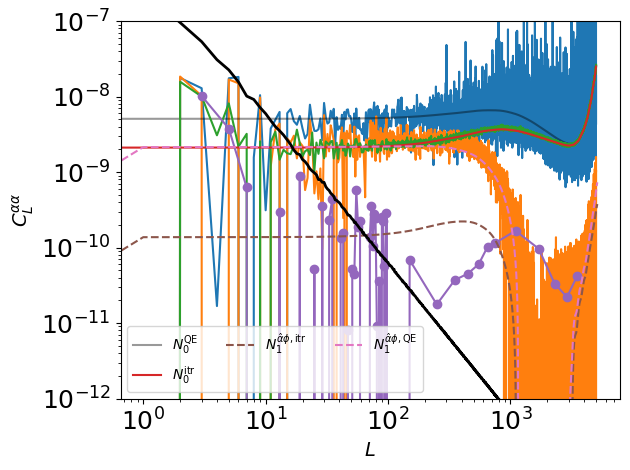

In [313]:
selected = ['a', 'p', 'o']

invWFs = {}

config_paths = ["official_check_factor_2", "official_check_factor_2", "official_a_disabled", "official_a_disabled", "official_so_a_disabled", "official", "alpha_after_lensing_sims", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation_no_curl_est"]#,  "config_full_no_alpha_no_curl_lensing_cmb_s4"]
config_paths = [f"configs/{config}.yaml" for config in config_paths]


bin_edges_B = np.arange(2, 100, 1)
bin_edges = np.concatenate([bin_edges_B, np.arange(100, 800, 100), np.arange(800, 4000, 600)])


bin_edges_B = np.arange(2, 100, 2)
bin_edges = np.concatenate([bin_edges_B, np.arange(100, 800, 100), np.arange(800, 4000, 600)])

decorator = lambda x: bin_theory(x, bin_edges)

ngg = np.loadtxt(f"{dir}n_gg_a_QE.txt")[:5001]

ngg_10 = np.loadtxt(f"{dir}ngg_a_itr_10.txt")[:5001]

n1_ap = np.loadtxt(f"/Users/omard/Documents/projects/jointmap/data/plots/noise_curves/noise_biases_cmb_s4/n1_ap_QE.txt")[:5001]
n1_ap_10 = np.loadtxt(f"/Users/omard/Documents/projects/jointmap/data/plots/noise_curves/noise_biases_cmb_s4/n1_ap_itr_10.txt")[:5001]
n1_aa_10 = np.loadtxt(f"/Users/omard/Documents/projects/jointmap/data/plots/noise_curves/noise_biases_cmb_s4/n1_aa_itr_10.txt")[:5001]


directory = "../data/plots/plot_alpha_data/"
N0_rand = np.loadtxt(directory+"N0_rand.txt")

for i, s in enumerate(selected[:1]):
    for j, config_path in enumerate(config_paths[:1]):
        selected, autoits, crossits, auto_input_its, _, _, crossits_lensed = process_config_npy(config_path)

        autos = autoits.mean(axis = 0)
        crosses = crossits.mean(axis = 0)
        crosses_lensed = crossits_lensed.mean(axis = 0)
        inputs = auto_input_its.mean(axis = 0)

        stdautos = autoits.std(axis = 0)

        autos_split = np.split(autos, len(selected), axis = -1)
        cross_split = np.split(crosses, len(selected), axis = -1)
        cross_lensed_split = np.split(crosses_lensed, len(selected), axis = -1)
        cross_split = cross_lensed_split

        """plt.loglog(cross_split[0][0]*WFth**-1.)

        plt.loglog(cross_split[0][-1]*WFth10**-1.)

        plt.loglog(inputs[0])
        plt.show()"""

        for itr in [0, autos.shape[0]-1]:
    
            WF = cross_split[i][itr]/inputs[i]
            el, WF_ = decorator_WF(WF)
            import scipy.interpolate
            WFf = scipy.interpolate.interp1d(el, WF_, kind = "linear", fill_value = "extrapolate")
            ls = np.arange(100, 5001)
            WFinterp = WFf(ls)
            WFother = WF.copy()
            WFother[100:] = WFinterp
            
            if itr == 0:
                WFQE = WF
            invWF = WF**-1.
            if j == 0:
                invWFs[s] = invWF

            #xx = autos_split[i][itr]*invWFs[s]**2.-inputs[i]

            #WF = WFth if itr == 0 else WFth10

            if i == 1:
                itr_ = 10 if itr in [15, 20] else itr
                N1plot = np.loadtxt(f"N1s_{itr_}.txt")
                N0plot = np.loadtxt(f"N0s_{itr_}.txt")
                plt.loglog(N1plot, ls = "--")
                plt.plot(N0plot, ls = "--")
                if itr == 20:
                    xx = autos_split[i][itr]*WF**-2.-auto_input_its[0][i]-N0plot[:5001]
                    plt.loglog(xx)


            if itr == 0:

                xx = autoits[0][itr][:5001]*WF**-2.-auto_input_its[0][i]-n1_ap[:5001]*(i == 0)
                plt.loglog(xx)

                #n1_aa = np.loadtxt(f"noise_biases{direc}/n1_aa_QE.txt")
                #plt.loglog(n1_aa, ls = "--")
                el, x = decorator(xx)
                
                #plt.plot(autos_split[i][itr]*WFth**-2.-nggs["a"][:5001]-inputs[i], color = "green")
               # plt.plot(autos_split[i][itr]*WFth**-2., color = "green")
                #plt.plot(el, x, lw = 2, label = r"$C_L^{\hat{\alpha}^{\mathrm{QE}}\hat{\alpha}^{\mathrm{QE}}}-C_L^{\alpha\alpha}-N_1^{\hat{\alpha}\phi}$")

                xx = autoits[0][itr][:5001]*WFth**-2.-auto_input_its[0][i]-ngg[:5001]
                el, x = decorator(xx)
                plt.plot(xx)
                #plt.plot(el, x)

                if i == 0:
                    plt.plot(ngg, color = "black", alpha = 0.4, label = r"$N_0^{\mathrm{QE}}$")
                
                #el, xy = decorator(autos_split[i][itr]*invWFs[s]**2.)
                #el, xy = decorator(autos_split[i][itr]*WFth**-2.)
                #plt.plot(el, xy, label = "WF normalized")
                #np.savetxt("x.txt", np.c_[el, xy])

                
                #el, xy = decorator(qe_alpha)
                #plt.plot(el, xy, ls = "--", label = "QE normalized")

            else:

                WFnorm = WFth10
                #WFnorm = WFother
                #WFnorm = WF
                
                xx = autoits[0][itr][:5001]*WFnorm**-2.-auto_input_its[0][i]
                plt.plot(xx)
                el, x = decorator(xx)
                #plt.plot(el, x, color = "brown", label = r"$C_L^{\hat{\alpha}^{\mathrm{QE}}\hat{\alpha}^{\mathrm{QE}}}-C_L^{\alpha\alpha}$")
                #el, x = decorator(autos_split[i][itr]*WF**-2.)
                #plt.plot(el, x, color = "red", ls = "--")
                if i == 0:
                    plt.plot(ngg_10, label = r"$N_0^{\mathrm{itr}}$")

                if i == 0:
                    xx = autoits[0][itr][:5001]*WFnorm**-2.-auto_input_its[0][i]-ngg_10[:5001]
                    el, x = decorator(xx)
                    #plt.loglog(xx)
                    plt.plot(el, x, marker = "o")

                if i == 0:
                    n1_ap = np.loadtxt(f"/Users/omard/Documents/projects/jointmap/data/plots/noise_curves/noise_biases_cmb_s4/n1_ap_itr_10.txt")
                    plt.loglog(n1_ap, label = r"$N_1^{\hat{\alpha}\phi, \mathrm{itr}}}$", ls = "--")

                #n1_aa = np.loadtxt(f"noise_biases{direc}/n1_aa_itr_10.txt")
                #plt.loglog(n1_aa, ls = ":")

    
        if i == 0:
            n1_ap = np.loadtxt(f"/Users/omard/Documents/projects/jointmap/data/plots/noise_curves/noise_biases_cmb_s4/n1_ap_QE.txt")
            plt.loglog(n1_ap, label = r"$N_1^{\hat{\alpha}\phi, \mathrm{QE}}}$", ls = "--")

        plt.plot(inputs[i], color = "black", lw = 2)#, label = r"$C_L^{\alpha\alpha}$")
        #plt.plot(nggs[s], lw = 2)
        #plt.plot(n0_bb)
        #plt.title(s)
        #print(a)
        #plt.xlim(5, 2000)
        #plt.savefig("")
        plt.yticks(fontsize = 18)
        
        plt.xticks(fontsize = 18)
        plt.xlabel(r"$L$", fontsize = 14)
    if s == "a":
        plt.ylabel(r"$C_L^{\alpha\alpha}$", fontsize = 14)
        if socase:
            #plt.ylim(1e-8, 5e-7)
            pass
        else:
            pass
        plt.ylim(1e-12, 1e-7)
        plt.tight_layout()
        plt.xscale("log")
        plt.yscale("log")
        #plt.xlim(3, 1000)
        plt.legend(ncol = 3, fontsize = 10)
        #plt.savefig(f"/users/odarwish/JointCMBiterative/figures/examples/alpha_improvements_{label}.pdf", dpi = 300)
    plt.show()

/Volumes/OmarFiles/joint_map_outputs//total_qe_it_cross_lensed_p_p_po_new_official_v2_po_new_0_63_15.npy


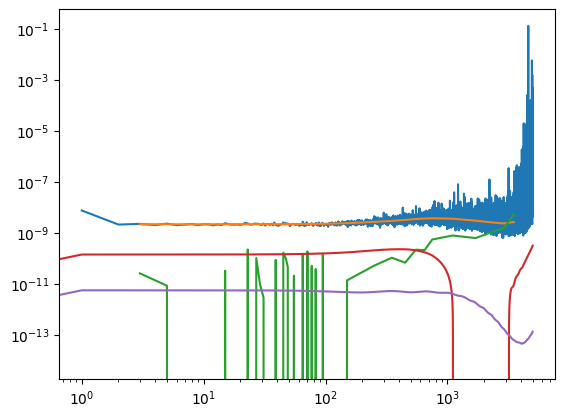

In [171]:
config_paths = [f"configs/{config}.yaml" for config in ["official_lensing_only"]]
selected, autoits_l, crossits_l, auto_input_its_l, _, _, crossits_lensed_l = process_config_npy(config_paths[0])

autos = autoits_l.mean(axis = 0)
crosses = crossits_l.mean(axis = 0)
crosses_lensed = crossits_lensed_l.mean(axis = 0)

inputs_d = auto_input_its_l.mean(axis = 0)

autos_split_d = np.split(autos, len(selected), axis = -1)
cross_split_d = np.split(crosses, len(selected), axis = -1)

xx = autos_split_d[i][itr]*WF**-2.#-inputs[i]
plt.loglog(xx)
plt.plot(*decorator(ngg_10[:5001]))
#plt.plot(xx-ngg_10[:5001])
plt.plot(*decorator(xx-ngg_10[:5001]))
plt.plot(n1_ap_10)
plt.plot(n1_aa_10)

In [231]:
dirij = "/Users/omard/Downloads/"
f0 = np.loadtxt(dirij+"final_mean_64_0.txt")
f15 = np.loadtxt(dirij+"final_mean_64_15.txt")
alpha = np.loadtxt(dirij+"alpha_sim.txt")
itr, itrx = np.loadtxt(dirij+"itr.txt").T
qe, qex = np.loadtxt(dirij+"qe.txt").T


/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_2121/4134284130.py:1: RuntimeWarning: divide by zero encountered in reciprocal
  xx = WFth**-1
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_2121/4134284130.py:2: RuntimeWarning: invalid value encountered in multiply
  plt.loglog(qe*xx**2)
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_2121/4134284130.py:3: RuntimeWarning: invalid value encountered in multiply
  factor = f0*xx**2
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_2121/4134284130.py:6: RuntimeWarning: invalid value encountered in multiply
  plt.plot(qe*xx**2-factor)


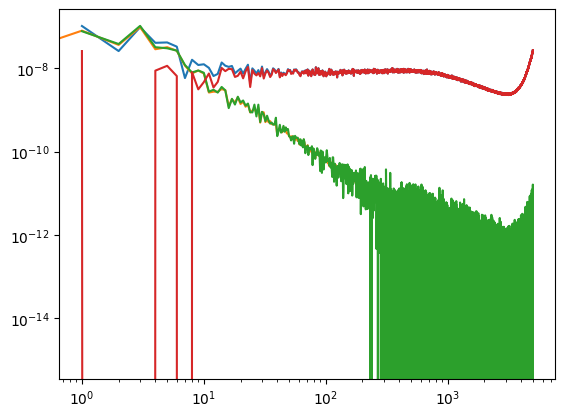

In [255]:
xx = WFth**-1
plt.loglog(qe*xx**2)
factor = f0*xx**2
plt.plot(alpha)
plt.loglog(factor)
plt.plot(qe*xx**2-factor)
#plt.loglog(qex*xx*factor)
#plt.plot(qe*xx**2*factor-qex*xx*factor)

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_2121/971021790.py:1: RuntimeWarning: divide by zero encountered in reciprocal
  xx = WFth10**-1.
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_2121/971021790.py:2: RuntimeWarning: invalid value encountered in multiply
  plt.loglog(itr*xx**2)
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_2121/971021790.py:3: RuntimeWarning: invalid value encountered in multiply
  factor = f15*xx**2
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_2121/971021790.py:7: RuntimeWarning: divide by zero encountered in power
  yy = autos_split[0][15]*WFth10**-2.-inputs[i]
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_2121/971021790.py:7: RuntimeWarning: invalid value encountered in multiply
  yy = autos_split[0][15]*WFth10**-2.-inputs[i]
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_2121/971021790.py:11: RuntimeWarning: invalid value encountered in multiply
  plt.plot(*decorator(itr*xx**2-fa

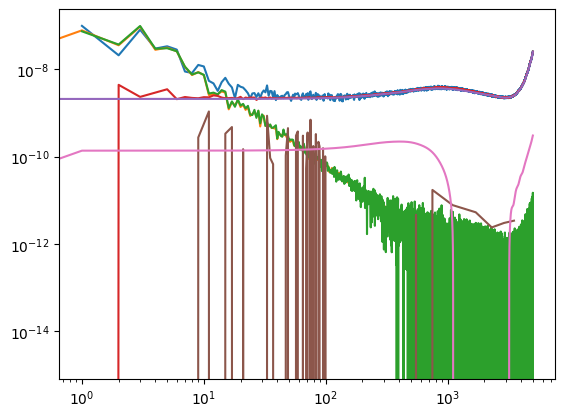

In [274]:
xx = WFth10**-1.
plt.loglog(itr*xx**2)
factor = f15*xx**2
plt.plot(alpha)
plt.loglog(factor)

yy = autos_split[0][15]*WFth10**-2.-inputs[i]
plt.plot(yy)
n = ngg_10[:5001]
plt.plot(n)
plt.plot(*decorator(itr*xx**2-factor-yy))
plt.plot(n1_ap_10)
#plt.loglog(itrx*xx*factor)
#plt.plot(itr*xx**2*factor-itrx*xx*factor)

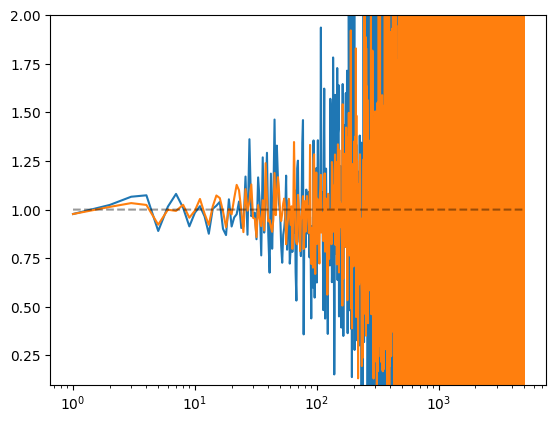

In [ ]:
xx = WFQE**-2
plt.plot(f0*xx/alpha)
xx = WF**-2
plt.plot(f15*xx/alpha)
#plt.plot(alpha)
plt.ylim(0.1, 2)
plt.xscale("log")
plt.plot(xx*0+1, color = "black", ls = "--", alpha = 0.4)

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_2121/3371272398.py:6: RuntimeWarning: divide by zero encountered in power
  f = WFd[itr]**-2.
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_2121/3371272398.py:7: RuntimeWarning: invalid value encountered in multiply
  plt.loglog(autoits_l[0, itr, :5001]*f)
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_2121/3371272398.py:8: RuntimeWarning: invalid value encountered in multiply
  plt.loglog(autoits[0, itr, :5001]*f)
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_2121/3371272398.py:10: RuntimeWarning: invalid value encountered in multiply
  delta = autoits[0, itr, :5001]*f-autoits_l[0, itr, :5001]*f
/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_2121/3371272398.py:15: RuntimeWarning: invalid value encountered in multiply
  delta = autoits_l[0, itr, :5001]*f-Nd[itr]


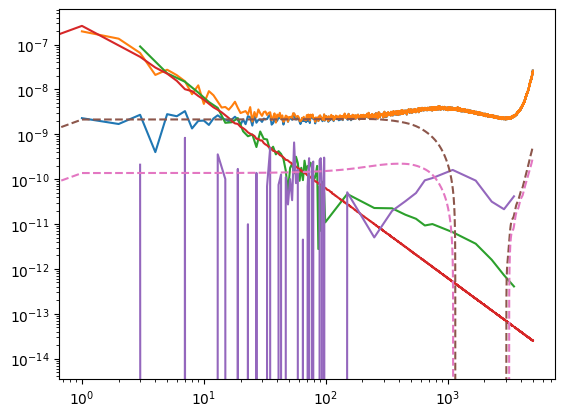

In [199]:
itr = 15
WFd = {0: WFth, 15: WFth10}
Nd = {0: ngg[:5001], 15: ngg_10[:5001]}

f = WFQE**-2.
f = WFd[itr]**-2.
plt.loglog(autoits_l[0, itr, :5001]*f)
plt.loglog(autoits[0, itr, :5001]*f)

delta = autoits[0, itr, :5001]*f-autoits_l[0, itr, :5001]*f
plt.plot(*decorator(delta))
plt.plot(inputs[0])


delta = autoits_l[0, itr, :5001]*f-Nd[itr]
plt.plot(*decorator(delta))
plt.plot(n1_ap, ls = "--")

plt.plot(n1_ap_10, ls = "--")

In [186]:
n1_aa/n1_ap*100

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_2121/648511796.py:1: RuntimeWarning: invalid value encountered in divide
  n1_aa/n1_ap*100


array([       nan, 0.167303  , 0.16729562, ..., 0.02178479, 0.02177256,
       0.02176022])

In [173]:
autoits_l.shape

(63, 16, 15003)

In [52]:
xx = autos_split[i][itr]*WFnorm**-2.-inputs[i]-ngg_10[:5001]
el, x = decorator(autos_split[i][itr]*WFth10**-2.-inputs[i]-ngg_10[:5001])

noise_10 = np.sqrt(WFnorm)**-1.*ngg_10[:5001]

/tmp/ipykernel_22286/2121542967.py:1: RuntimeWarning: divide by zero encountered in power
  xx = autos_split[i][itr]*WFnorm**-2.-inputs[i]-ngg_10[:5001]
/tmp/ipykernel_22286/2121542967.py:1: RuntimeWarning: invalid value encountered in multiply
  xx = autos_split[i][itr]*WFnorm**-2.-inputs[i]-ngg_10[:5001]
/tmp/ipykernel_22286/2121542967.py:2: RuntimeWarning: divide by zero encountered in power
  el, x = decorator(autos_split[i][itr]*WFth10**-2.-inputs[i]-ngg_10[:5001])
/tmp/ipykernel_22286/2121542967.py:2: RuntimeWarning: invalid value encountered in multiply
  el, x = decorator(autos_split[i][itr]*WFth10**-2.-inputs[i]-ngg_10[:5001])
/tmp/ipykernel_22286/2121542967.py:4: RuntimeWarning: divide by zero encountered in reciprocal
  noise_10 = np.sqrt(WFnorm)**-1.*ngg_10[:5001]


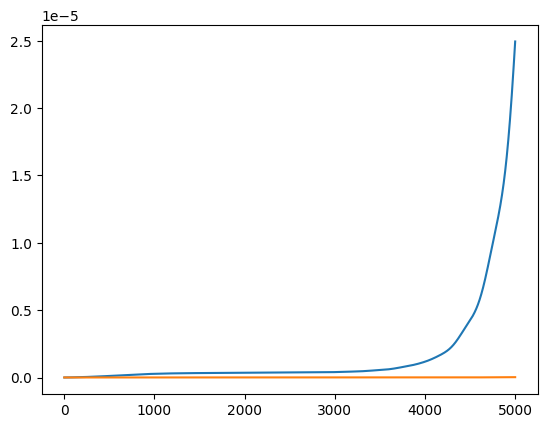

In [53]:
plt.plot(noise_10)
plt.plot(ngg_10)

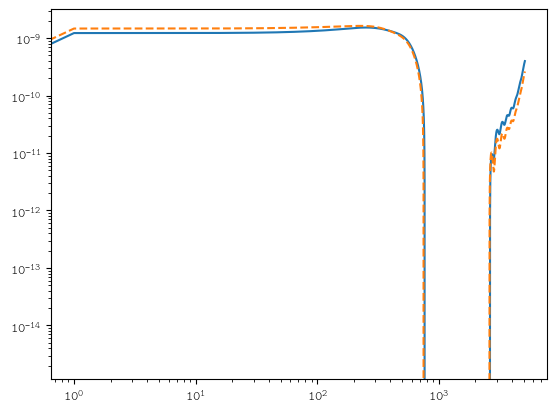

In [52]:
n1_ap = np.loadtxt(f"noise_biases{direc}/n1_ap_itr_10.txt")
plt.loglog(n1_ap)
n1_ap = np.loadtxt(f"noise_biases{direc}/n1_ap_QE.txt")
plt.loglog(n1_ap/2, ls = "--")

In [29]:
cross_phi = {0: {0: [], 15: []}, 1: {0: [], 15: []}}

def plot_configs_with_class(config_paths, subset_selected, itrs, outname):
    config_data = [process_config_npy(config_path) for config_path in config_paths]

    N_configs = len(config_paths)
    rows = len(subset_selected)
    cols = N_configs

    names_fields = {"p": r"$\phi$", "o": r"$\omega$", "f": r"$\tau$", "a": r"$\alpha$"}

    # Initialize CMBLensingPlot
    plot = CMBLensingPlot(rows=rows, cols=cols, figsize=(10, 6), sharex=True, sharey = False, outdir = "../plots/")

    for j, (selected, autoits, crossits, auto_input_its, crossits_down, auto_input_down_its) in enumerate(config_data):  # Iterate over configurations
            
            autos = autoits.mean(axis = 0)
            crosses = crossits.mean(axis = 0)
            inputs = auto_input_its.mean(axis = 0)

            crosses_down = crossits_down.mean(axis = 0)
            inputs_down = auto_input_down_its.mean(axis = 0)

            stdautos = autoits.std(axis = 0)

            autos_split = np.split(autos, len(selected), axis = -1)
            cross_split = np.split(crosses, len(selected), axis = -1)

            cross_down_split = np.split(crosses_down, len(selected), axis = -1)

            for i, k in enumerate(subset_selected):  # Iterate over estimators

                original_idx = selected.index(k)
            
                for idx, itr in enumerate(itrs):  # Iterate over iterations
                    
                    el, cross = cross_corr_coeff_from_cl(autos_split[original_idx][itr], inputs[original_idx], cross_split[original_idx][itr], plot=False)

                    if k=="p":
                         cross_phi[j][itr] = autos_split[original_idx][itr]

                    el, cross_down = cross_corr_coeff_from_cl(autos_split[original_idx][itr], inputs_down[original_idx], cross_down_split[original_idx][itr], plot=False)
                    plot.add_curve(el, cross, label=f"itr {itr}", row=i, col=j, linewidth = 1.5)
                    plot.add_curve(el, cross_down, label=f"itr {itr}", row=i, col=j, linewidth = 1.5, linestyle="--")

                plot.set_labels(xlabel=r"$L$", ylabel=r"$\rho_L$" + f"({names_fields[k]})", row=i, col=j)
                plot.set_xlim(xmin = 5, xmax = 1000, row = i, col = j)

                plot.set_scale(xscale="log", row=i, col=j)
                """if k == "a":
                     plot.set_ylim(row = i, col = j, ymin = 0, ymax = 0.6)
                elif k == "o":
                    plot.set_ylim(row = i, col = j, ymin = 0, ymax = 0.3)"""
                if i == 0:
                    plot.set_title(k, row=i, col=j)
                    if j == 0:
                        plot.set_legend(row=i, col=j, fontsize = 10)

    #plot.save_plot(outname, dpi=300)
    plot.show_plot()

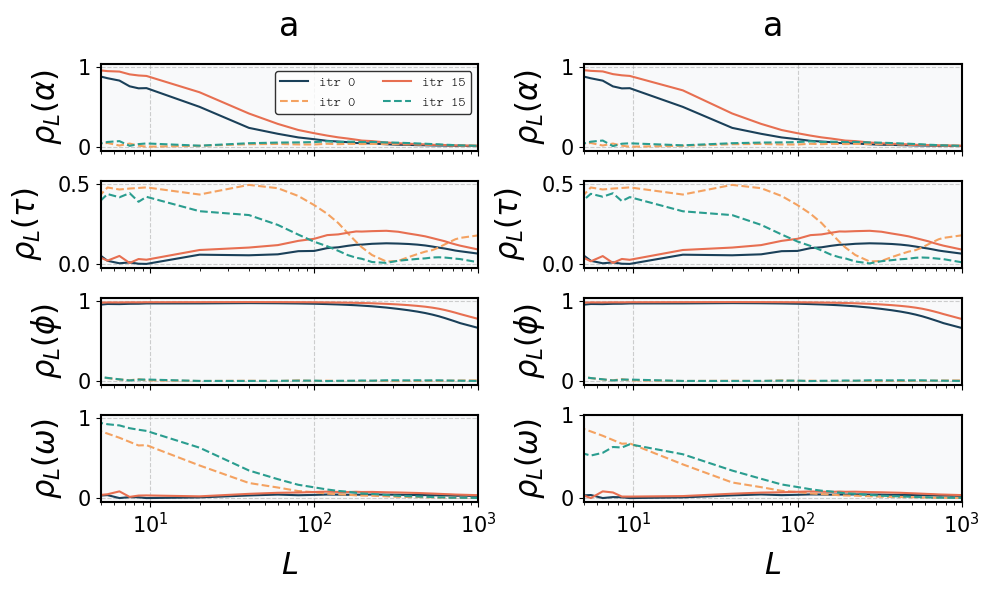

In [30]:
config_paths = ["official_multiple_disabled",  "official_multiple", "official_deep_multiple", "official_multiple", "official_multiple_disabled", "official_so_a_disabled", "alpha_after_lensing_sims", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation_no_curl_est"]#,  "config_full_no_alpha_no_curl_lensing_cmb_s4"]
config_paths = [f"configs/{config}.yaml" for config in config_paths]
config_paths = config_paths[:2]

subset_selected = ["a", "f", "p", "o"]
itrs = [0, 15]#, 15]
outname = ""
plot_configs_with_class(config_paths, subset_selected, itrs, outname)

In [31]:
cross_phi

{0: {0: array([0.00000000e+00, 0.00000000e+00, 7.87969107e-09, ...,
         1.61770824e-26, 1.61511759e-26, 1.61331630e-26]),
  15: array([0.00000000e+00, 0.00000000e+00, 7.75256360e-09, ...,
         1.54413683e-26, 1.54466070e-26, 1.54153783e-26])},
 1: {0: array([0.00000000e+00, 0.00000000e+00, 7.87969108e-09, ...,
         1.61770824e-26, 1.61511759e-26, 1.61331630e-26]),
  15: array([0.00000000e+00, 0.00000000e+00, 6.51813693e-09, ...,
         1.54412751e-26, 1.54463366e-26, 1.54153951e-26])}}

/tmp/ipykernel_26833/3116759026.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(cross_phi[0][15]/cross_phi[1][15])


(0.95, 1.05)

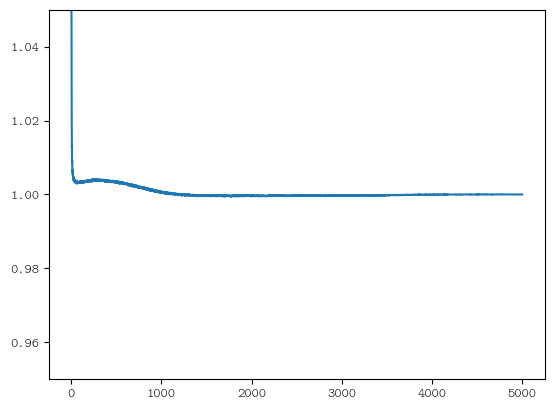

In [35]:
plt.plot(cross_phi[0][15]/cross_phi[1][15])
plt.ylim(0.95, 1.05)